In [12]:
import cleanlab
import sys
import numpy as np
import pandas as pd
import datetime
import copy
import math
from pathlib import Path
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, precision_recall_curve
from matplotlib import pyplot as plt

sys.path.insert(0, "../")
from eval_metrics import lift_at_k

from cleanlab.rank import order_label_issues, get_label_quality_scores, get_label_quality_ensemble_scores
from cleanlab.filter import find_label_issues

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Evaluate scores

In [16]:
%%time

models = [
    "resnet18", 
    "resnet50d",
    "efficientnet_b1",
    "twins_pcpvt_base",
    "swin_base_patch4_window7_224"
]

# args to pass to get_label_quality_scores()
score_params = \
[
    ("self_confidence", False),
    ("self_confidence", True),
    ("normalized_margin", False),
    ("normalized_margin", True),
    ("confidence_weighted_entropy", False)
]

results_list = []
pred_probs_list = [] # use for ensemble scoring
labels_list = [] # use for sanity check (labels from each model should be the same because they were generated from the same cross-val procedure

for model in models:
    
    # read numpy files
    numpy_out_folder = f"./cifar-10n-png_noise_type_worst_cv_{model}/"
    pred_probs = np.load(numpy_out_folder + "pred_probs.npy")
    labels = np.load(numpy_out_folder + "noisy_labels.npy")
    true_labels = np.load(numpy_out_folder + "true_labels.npy")
    images = np.load(numpy_out_folder + "images.npy", allow_pickle=True)
    
    # boolean mask of label errors
    label_errors_target = labels != true_labels
    
    # save to list for ensemble scoring
    pred_probs_list.append(pred_probs)
    
    labels_list.append(labels)
    
    for score_param in score_params:
        
        method, adjust_pred_probs = score_param

        # compute scores
        label_quality_scores = get_label_quality_scores(labels=labels, pred_probs=pred_probs, method=method, adjust_pred_probs=adjust_pred_probs)

        # compute accuracy of detecting label errors
        auroc = roc_auc_score(label_errors_target, 1 - label_quality_scores)

        # compute Lift@K evaluation metric
        lift_at_k_dict = {}
        for k in range(1000, 21000, 1000):
            lift_at_k_dict[f"lift_at_{k}"] = lift_at_k(label_errors_target, 1 - label_quality_scores, k=k)

        # save results
        results = {
            "dataset": "cifar-10n",
            "model": model,
            "noise_type": "worse_label",
            "method": method,
            "adjust_pred_probs": adjust_pred_probs,
            "auroc": auroc
        }

        # add the lift at k metrics
        results.update(lift_at_k_dict)

        # save results
        results_list.append(results)        

CPU times: user 28.6 s, sys: 27.7 ms, total: 28.6 s
Wall time: 28.6 s


In [19]:
# use for sanity check (noisy labels from each model should be the same because they were generated from the same cross-val procedure
for i, labels_temp in enumerate(labels_list):
    
    if i == 0:
        # labels_temp_previous = labels_temp.copy()
        labels_temp_previous = copy.deepcopy(labels_temp)
    else:
        assert (labels_temp_previous == labels_temp).all()

## Evaluate ensemble scores

In [20]:
%%time

for score_param in score_params:

    method, adjust_pred_probs = score_param
    
    print(f"Scoring label quality...")
    print(f"  method: {method}")
    print(f"  adjust_pred_probs: {adjust_pred_probs}")

    label_quality_ensemble_scores = get_label_quality_ensemble_scores(labels, pred_probs_list, method=method, adjust_pred_probs=adjust_pred_probs)
    
    # compute accuracy of detecting label errors
    auroc = roc_auc_score(label_errors_target, 1 - label_quality_ensemble_scores)

    # compute Lift@K evaluation metric
    lift_at_k_dict = {}
    for k in range(1000, 21000, 1000):
        lift_at_k_dict[f"lift_at_{k}"] = lift_at_k(label_errors_target, 1 - label_quality_ensemble_scores, k=k)

    # save results
    results = {
        "dataset": "cifar-10n",
        "model": "ensemble (all)",
        "noise_type": "worse_label",
        "method": method,
        "adjust_pred_probs": adjust_pred_probs,
        "auroc": auroc
    }

    # add the lift at k metrics
    results.update(lift_at_k_dict)
    
    # save results
    results_list.append(results)

Scoring label quality...
  method: self_confidence
  adjust_pred_probs: False
Weighting scheme for ensemble: accuracy
Ensemble members will be weighted by: their relative accuracy
  Model 0 accuracy : 0.57788
  Model 0 weights  : 0.19538551006883867
  Model 1 accuracy : 0.5919
  Model 1 weights  : 0.20012577595650588
  Model 2 accuracy : 0.5804
  Model 2 weights  : 0.19623754074194294
  Model 3 accuracy : 0.60154
  Model 3 weights  : 0.20338513138853953
  Model 4 accuracy : 0.60592
  Model 4 weights  : 0.2048660418441731
Scoring label quality...
  method: self_confidence
  adjust_pred_probs: True
Weighting scheme for ensemble: accuracy
Ensemble members will be weighted by: their relative accuracy
  Model 0 accuracy : 0.57788
  Model 0 weights  : 0.19538551006883867
  Model 1 accuracy : 0.5919
  Model 1 weights  : 0.20012577595650588
  Model 2 accuracy : 0.5804
  Model 2 weights  : 0.19623754074194294
  Model 3 accuracy : 0.60154
  Model 3 weights  : 0.20338513138853953
  Model 4 accura

## Create DataFrame with results

In [21]:
df = pd.DataFrame(results_list)

In [22]:
df

,dataset,model,noise_type,method,adjust_pred_probs,auroc,lift_at_1000,lift_at_2000,lift_at_3000,lift_at_4000,lift_at_5000,lift_at_6000,lift_at_7000,lift_at_8000,lift_at_9000,lift_at_10000,lift_at_11000,lift_at_12000,lift_at_13000,lift_at_14000,lift_at_15000,lift_at_16000,lift_at_17000,lift_at_18000,lift_at_19000,lift_at_20000
0,cifar-10n,resnet18,worse_label,self_confidence,False,0.963435,2.487067,2.487067,2.487067,2.485202,2.484580,2.482508,2.479606,2.474321,2.469381,2.460953,2.449987,2.435668,2.418386,2.396645,2.372165,2.338465,2.307852,2.267929,2.226972,2.178547
1,cifar-10n,resnet18,worse_label,self_confidence,True,0.956146,2.484580,2.470901,2.453077,2.439813,2.431357,2.433595,2.433062,2.427067,2.422127,2.417927,2.406577,2.395046,2.377636,2.357917,2.336185,2.306755,2.275228,2.238913,2.200138,2.153552
2,cifar-10n,resnet18,worse_label,normalized_margin,False,0.966803,2.487067,2.482093,2.482093,2.477119,2.472642,2.468414,2.462552,2.457533,2.452525,2.446777,2.435291,2.423440,2.411499,2.396289,2.379129,2.357895,2.328041,2.293767,2.252628,2.202795
3,cifar-10n,resnet18,worse_label,normalized_margin,True,0.966067,2.484580,2.479606,2.476290,2.473388,2.469658,2.465098,2.461486,2.456290,2.451972,2.445036,2.433708,2.421574,2.409203,2.393802,2.372994,2.347791,2.319995,2.286582,2.247654,2.201925
4,cifar-10n,resnet18,worse_label,confidence_weighted_entropy,False,0.954042,2.487067,2.484580,2.482093,2.480850,2.480601,2.477948,2.473566,2.466549,2.457499,2.444787,2.430091,2.411833,2.390454,2.360049,2.331377,2.294630,2.257964,2.220675,2.174613,2.127064
5,cifar-10n,resnet50d,worse_label,self_confidence,False,0.975780,2.487067,2.487067,2.485409,2.485824,2.485575,2.483751,2.482448,2.480539,2.477119,2.472394,2.468075,2.459088,2.445361,2.426845,2.404828,2.379035,2.354960,2.325546,2.291767,2.249925
6,cifar-10n,resnet50d,worse_label,self_confidence,True,0.971084,2.484580,2.458466,2.458051,2.460331,2.460207,2.458880,2.453669,2.451937,2.451419,2.448766,2.444335,2.438569,2.425273,2.409258,2.386921,2.360227,2.333454,2.304820,2.270823,2.233759
7,cifar-10n,resnet50d,worse_label,normalized_margin,False,0.979797,2.482093,2.480850,2.479606,2.477741,2.475129,2.472559,2.469658,2.468414,2.466342,2.464684,2.460840,2.456393,2.448613,2.441057,2.427212,2.413543,2.396362,2.366168,2.330382,2.284620
8,cifar-10n,resnet50d,worse_label,normalized_margin,True,0.980028,2.484580,2.479606,2.477119,2.477119,2.473637,2.471730,2.471079,2.468103,2.464407,2.462197,2.457901,2.455772,2.451674,2.439991,2.427875,2.413232,2.394314,2.365063,2.329989,2.284869
9,cifar-10n,resnet50d,worse_label,confidence_weighted_entropy,False,0.968417,2.487067,2.485824,2.486238,2.483958,2.482591,2.480850,2.477830,2.474321,2.471592,2.466176,2.458805,2.448310,2.433691,2.411745,2.377968,2.345149,2.310924,2.278154,2.242549,2.204909


## Export results to csv

In [23]:
# export results to CSV file
ts = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
df.to_csv(f"label_quality_scores_evaluation_{ts}.csv", index=False)

## Evaluate precision-recall and F1-score

In [2]:
model = "swin_base_patch4_window7_224"
# model = "twins_pcpvt_base"

# read numpy files
numpy_out_folder = f"./cifar-10n-png_noise_type_worst_cv_{model}/"

pred_probs = np.load(numpy_out_folder + "pred_probs.npy")
labels = np.load(numpy_out_folder + "noisy_labels.npy")
true_labels = np.load(numpy_out_folder + "true_labels.npy")
images = np.load(numpy_out_folder + "images.npy", allow_pickle=True)

# boolean mask of label errors
label_errors_target = labels != true_labels

In [3]:
label_errors_target.mean()

0.40208

In [4]:
label_issues = cleanlab.filter.find_label_issues(labels=labels, pred_probs=pred_probs, filter_by="predicted_neq_given")

In [5]:
label_issues.sum()

19704

In [6]:
# datapoints where pred_prob argmax does not equal the noisy label
(pred_probs.argmax(axis=1) != labels).sum()

19704

In [7]:
(pred_probs.argmax(axis=1) == true_labels).mean()

0.94302

## Evaluate different filter_by options

In [57]:
filter_by_list = [
    "prune_by_noise_rate",
    "prune_by_class",
    "both",
    "confident_learning",
    "predicted_neq_given",
]

results = []

for filter_by in filter_by_list:

    label_issues = find_label_issues(
        labels=labels,
        pred_probs=pred_probs,
        filter_by=filter_by,
    )

    # Calculate evaluation metrics
    f1 = f1_score(label_errors_target, label_issues)
    precision = precision_score(label_errors_target, label_issues)
    recall = recall_score(label_errors_target, label_issues)

    result = {
        "filter_by": filter_by,
        "num_label_issues": sum(label_issues),
        "f1_score": f1,
        "precision": precision,
        "recall": recall
    }

    print(result)
    
    results.append(result)

{'filter_by': 'prune_by_noise_rate', 'num_label_issues': 17872, 'f1_score': 0.9236359806193385, 'precision': 0.9813115487914056, 'recall': 0.8723637087146836}
{'filter_by': 'prune_by_class', 'num_label_issues': 18347, 'f1_score': 0.9383891186185015, 'precision': 0.98332152395487, 'recall': 0.897383605252686}
{'filter_by': 'both', 'num_label_issues': 17280, 'f1_score': 0.9133319066980528, 'precision': 0.9879629629629629, 'recall': 0.8491842419419021}
{'filter_by': 'confident_learning', 'num_label_issues': 16888, 'f1_score': 0.8917063148788927, 'precision': 0.976610611084794, 'recall': 0.8203840031834461}
{'filter_by': 'predicted_neq_given', 'num_label_issues': 19704, 'f1_score': 0.9527230707395499, 'precision': 0.9623934226552984, 'recall': 0.9432451253481894}


In [59]:
print(f"model: {model}")
print(f"cross-val procedure: stratified k-folds (k=5)")
print(f"dataset: cifar-10n")
print(f"noise type: worse (40% noise rate)")
print()
print(f"Label Error Detection: Evaluating Different filter_by:")
print()
df_filter_by = pd.DataFrame(results)
df_filter_by

model: swin_base_patch4_window7_224
cross-val procedure: stratified k-folds (k=5)
dataset: cifar-10n
noise type: worse (40% noise rate)

Label Error Detection: Evaluating Different filter_by:



,filter_by,num_label_issues,f1_score,precision,recall
0,prune_by_noise_rate,17872,0.923636,0.981312,0.872364
1,prune_by_class,18347,0.938389,0.983322,0.897384
2,both,17280,0.913332,0.987963,0.849184
3,confident_learning,16888,0.891706,0.976611,0.820384
4,predicted_neq_given,19704,0.952723,0.962393,0.943245


In [63]:
for index, row in df_filter_by.iterrows():
    filter_by = row["filter_by"]
    precision = row["precision"]
    recall = row["recall"]

## Plot precision-recall curve

Scoring label quality...
  method: self_confidence
  adjust_pred_probs: False
Scoring label quality...
  method: normalized_margin
  adjust_pred_probs: False
Scoring label quality...
  method: confidence_weighted_entropy
  adjust_pred_probs: False


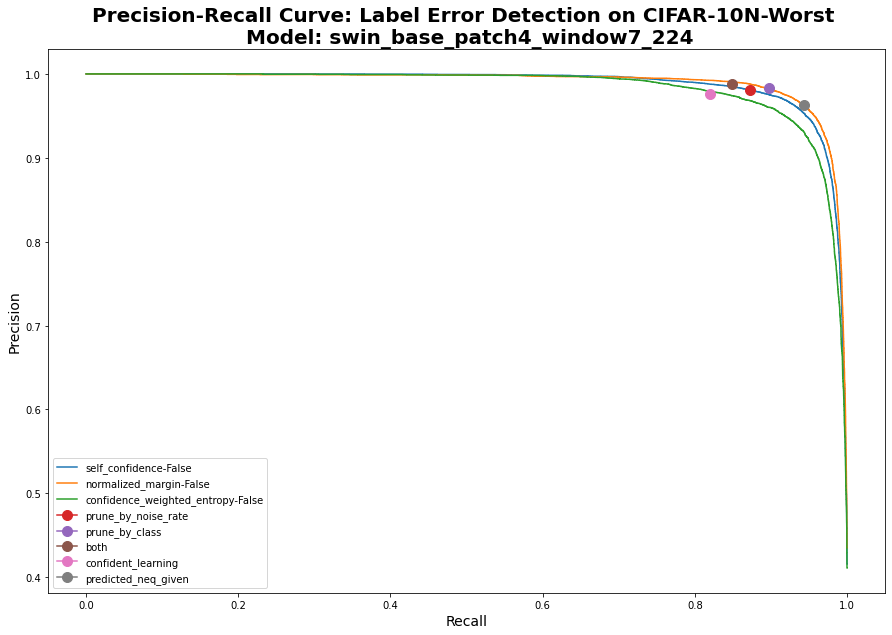

CPU times: user 4.17 s, sys: 175 ms, total: 4.35 s
Wall time: 4.09 s


In [66]:
%%time

plt.rcParams["figure.figsize"] = (15, 10)

score_params = \
[
    ("self_confidence", False),
    # ("self_confidence", True),
    ("normalized_margin", False),
    # ("normalized_margin", True),
    ("confidence_weighted_entropy", False)
]

df_list = []

for score_param in score_params:

    method, adjust_pred_probs = score_param
    
    print(f"Scoring label quality...")
    print(f"  method: {method}")
    print(f"  adjust_pred_probs: {adjust_pred_probs}")

    label_quality_scores = get_label_quality_scores(labels, pred_probs, method=method, adjust_pred_probs=adjust_pred_probs)

    # compute accuracy of detecting label errors
    auroc = roc_auc_score(label_errors_target, 1 - label_quality_scores)

    # compute precision-recall curve
    precision, recall, thresholds = precision_recall_curve(label_errors_target, 1 - label_quality_scores)

    # save to DataFrame
    # ignore last precision, recall value because it's always 1, 0 respectively with no corresponding threshold
    # https://stackoverflow.com/questions/31639016/in-scikits-precision-recall-curve-why-does-thresholds-have-a-different-dimensi
    df_temp = pd.DataFrame({
        "precision": precision[:-1],
        "recall": recall[:-1],
        "thresholds": thresholds,
        "model": model,
        "method": method,
        "adjust_pred_probs": adjust_pred_probs
    })

    df_list.append(df_temp)
    
    # plot
    plt.plot(recall, precision, label=f"{method}-{str(adjust_pred_probs)}")
    
# combine DataFrames
# df_all = pd.concat(df_list)

# plot single dot (precision, recall) for each filter_by option
for index, row in df_filter_by.iterrows():
    filter_by = row["filter_by"]
    precision = row["precision"]
    recall = row["recall"]
    plt.plot(recall, precision, marker="o", markersize=10, label=filter_by)

plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title("Precision-Recall Curve: Label Error Detection on CIFAR-10N-Worst \n Model: swin_base_patch4_window7_224", fontsize=20, fontweight="bold")
# plt.suptitle("")
plt.legend()
plt.show()

Scoring label quality...
  method: self_confidence
  adjust_pred_probs: True
Scoring label quality...
  method: normalized_margin
  adjust_pred_probs: True
Scoring label quality...
  method: confidence_weighted_entropy
  adjust_pred_probs: False


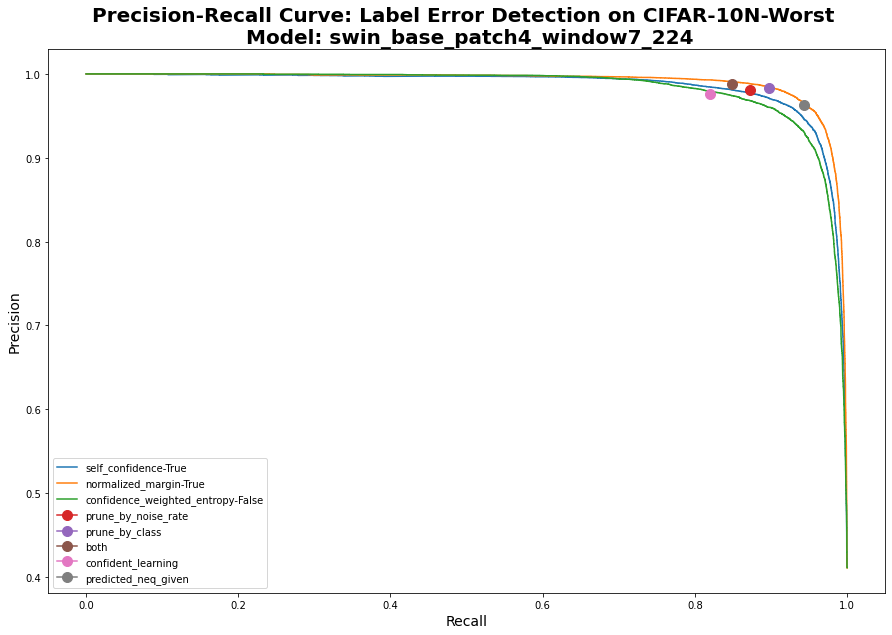

CPU times: user 4.14 s, sys: 138 ms, total: 4.28 s
Wall time: 4.02 s


In [68]:
%%time

plt.rcParams["figure.figsize"] = (15, 10)

score_params = \
[
    # ("self_confidence", False),
    ("self_confidence", True),
    # ("normalized_margin", False),
    ("normalized_margin", True),
    ("confidence_weighted_entropy", False)
]

df_list = []

for score_param in score_params:

    method, adjust_pred_probs = score_param
    
    print(f"Scoring label quality...")
    print(f"  method: {method}")
    print(f"  adjust_pred_probs: {adjust_pred_probs}")

    label_quality_scores = get_label_quality_scores(labels, pred_probs, method=method, adjust_pred_probs=adjust_pred_probs)

    # compute accuracy of detecting label errors
    auroc = roc_auc_score(label_errors_target, 1 - label_quality_scores)

    # compute precision-recall curve
    precision, recall, thresholds = precision_recall_curve(label_errors_target, 1 - label_quality_scores)

    # save to DataFrame
    # ignore last precision, recall value because it's always 1, 0 respectively with no corresponding threshold
    # https://stackoverflow.com/questions/31639016/in-scikits-precision-recall-curve-why-does-thresholds-have-a-different-dimensi
    df_temp = pd.DataFrame({
        "precision": precision[:-1],
        "recall": recall[:-1],
        "thresholds": thresholds,
        "model": model,
        "method": method,
        "adjust_pred_probs": adjust_pred_probs
    })

    df_list.append(df_temp)
    
    # plot
    plt.plot(recall, precision, label=f"{method}-{str(adjust_pred_probs)}")
    
# combine DataFrames
# df_all = pd.concat(df_list)

# plot single dot (precision, recall) for each filter_by option
for index, row in df_filter_by.iterrows():
    filter_by = row["filter_by"]
    precision = row["precision"]
    recall = row["recall"]
    plt.plot(recall, precision, marker="o", markersize=10, label=filter_by)

plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title("Precision-Recall Curve: Label Error Detection on CIFAR-10N-Worst \n Model: swin_base_patch4_window7_224", fontsize=20, fontweight="bold")
# plt.suptitle("")
plt.legend()
plt.show()

In [41]:


# plt.plot(recall, precision, label=f"{method}-{str(adjust_pred_probs)}")
# plt.legend()
plt.show()

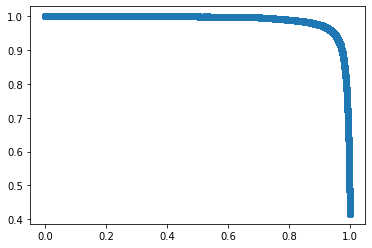

In [20]:
# plot

plt.scatter(
    x=recall, 
    y=precision
)

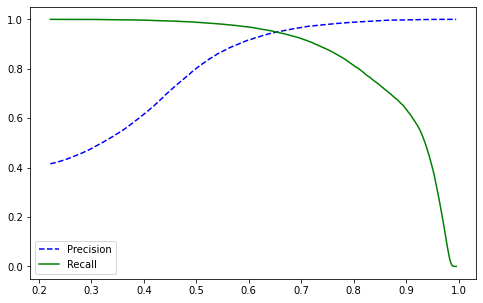

In [27]:
def plot_precision_recall_vs_threshold(precisions, recall, thresholds): 
    fig = plt.figure(figsize= (8,5))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recall[:-1], "g-", label="Recall")
    plt.legend()

plot_precision_recall_vs_threshold(precision, recall, thresholds)

## Visualize top N images ordered by label quality score

In [4]:
model = "swin_base_patch4_window7_224"

# read numpy files
numpy_out_folder = f"./cifar-10n-png_noise_type_worst_cv_{model}/"

pred_probs = np.load(numpy_out_folder + "pred_probs.npy")
labels = np.load(numpy_out_folder + "noisy_labels.npy")
true_labels = np.load(numpy_out_folder + "true_labels.npy")
images = np.load(numpy_out_folder + "images.npy", allow_pickle=True)

# boolean mask of label errors
label_errors_target = labels != true_labels



model = "swin_base_patch4_window7_224"
method = "self_confidence"
adjust_pred_probs = False

# get label quality scores (again)
label_quality_scores = get_label_quality_scores(labels=labels, pred_probs=pred_probs, method=method, adjust_pred_probs=adjust_pred_probs)

In [15]:
df_temp = pd.DataFrame({
    "label_quality_scores": label_quality_scores,
    "images": images,
    "labels": labels,
    "label_errors_target": label_errors_target
})

In [16]:
df_temp.head()

,label_quality_scores,images,labels,label_errors_target
0,0.053638,/Data/cifar-10n-png/train/image_id_0.png,4,True
1,0.554308,/Data/cifar-10n-png/train/image_id_1.png,9,False
2,0.120817,/Data/cifar-10n-png/train/image_id_2.png,0,True
3,0.074822,/Data/cifar-10n-png/train/image_id_3.png,5,True
4,0.633071,/Data/cifar-10n-png/train/image_id_4.png,1,False


In [21]:
df_filtered.head()

,label_quality_scores,images,labels,label_errors_target
9640,0.004542,/Data/cifar-10n-png/train/image_id_9649.png,2,True
817,0.005963,/Data/cifar-10n-png/train/image_id_817.png,6,True
40169,0.006814,/Data/cifar-10n-png/train/image_id_40120.png,9,True
34099,0.007057,/Data/cifar-10n-png/train/image_id_34099.png,6,True
20081,0.007917,/Data/cifar-10n-png/train/image_id_19880.png,7,True


In [17]:
# classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


TOP_K = 20
df_filtered = df_temp.sort_values(by="label_quality_scores", ascending=True).head(TOP_K)

# list of image paths
# e.g. "../data/train/i/foo.png"
image_paths = df_filtered.images.tolist()
image_labels = df_filtered.labels.tolist()
image_errors = df_filtered.label_errors_target.tolist()



# configure grid
fig_size = 13  # resolution; 1 = 100px
num_cols = 5  # set the number of desired columns


def viz_top_k_image_label_issues(
    image_paths,
    image_labels,
    image_errors,
    title="Top K Images",
    fig_size=12,
    num_cols=5,
    save_path="grid_temp.png"
):
    
    # count of images
    image_cnt = len(image_paths)

    # create plot
    num_rows = math.ceil(
        image_cnt / num_cols
    )  # number of rows will be automatically set
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_size, fig_size))

    # loop through each image
    for idx, image_path in enumerate(image_paths):

        # given label
        given_label = classes[image_labels[idx]]

        # set the position of the image on the grid
        row_pos = idx // num_cols
        col_pos = idx % num_cols

        # read image
        plt_image = plt.imread(image_path)

        # show image
        axes[row_pos, col_pos].axis("off")
        #     axes[row_pos, col_pos].set_facecolor('xkcd:salmon')

        error = image_errors[idx]
        title_color = ("b", "r")[error]

        axes[row_pos, col_pos].set_title(
            f"Given label: {given_label}", size=10, fontweight="bold", color=title_color
        )
        axes[row_pos, col_pos].imshow(plt_image)

    plt.suptitle(title, size=14, fontweight="bold")
    # plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
    # plt.savefig(save_path)

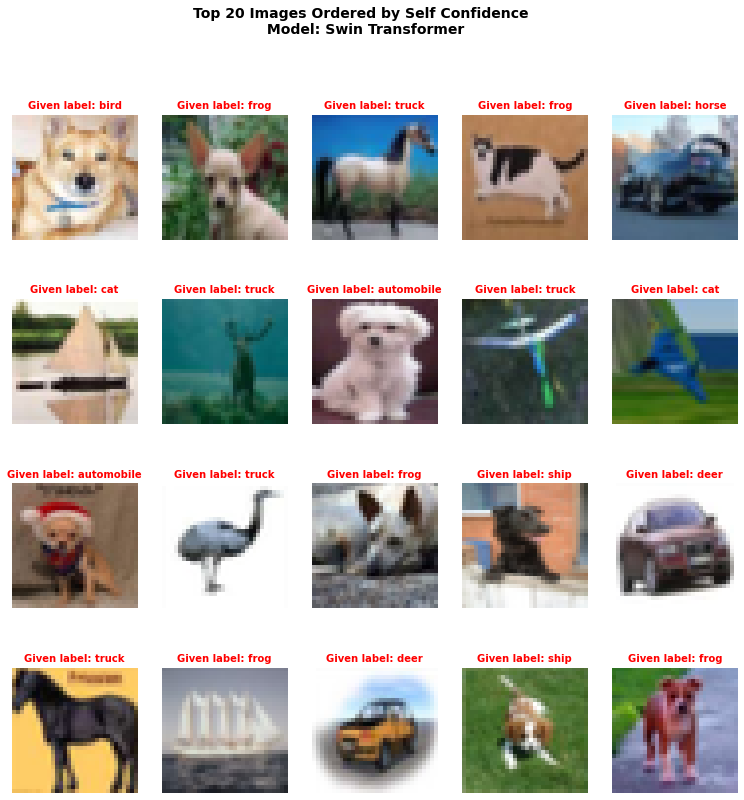

In [19]:
title = f"Top 20 Images Ordered by Self Confidence \n Model: Swin Transformer"

viz_top_k_image_label_issues(image_paths=image_paths, image_labels=image_labels, image_errors=image_errors, title=title, fig_size=13)